# Comarket Movement Exploration using Facebook Prophet Model


Author: Brandon Fan

## Initial Exploration

In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_yearly

In [2]:
bull_market_prices = pd.read_csv('./data/bull-market.csv')
prices_2008 = pd.read_csv('./data/2008-market.csv')
prices_2018 = pd.read_csv('./data/2018-market.csv')

/Users/brandonfan/opt/anaconda3/envs/stocks/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
def get_prices(ticker, year='2010'):
    if year == '2008':
        return prices_2008[prices_2008['tic'] == ticker]
    elif year == '2018':
        return prices_2018[prices_2018['tic'] == ticker]
    else:
        return bull_market_prices[bull_market_prices['tic'] == ticker]

In [56]:
def format_prophet_data(df):
    new_df = df[['datadate', 'prccd']].copy()
    new_df = new_df.rename(columns={'datadate': 'ds', 'prccd': 'y'})
    new_df['ds'] = pd.to_datetime(new_df['ds'], format='%m/%d/%Y')
#     new_df['y'] = (new_df['y'].shift(1) - new_df['y']) / new_df['y']
    return new_df

In [57]:
test = get_prices('ABT')
test_prophet_data = format_prophet_data(test)

In [58]:
def display_components(df):
    m = Prophet(yearly_seasonality=10, weekly_seasonality=3, seasonality_mode='additive')
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(df)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    return m.plot_components(forecast)

In [59]:
def get_components(ticker, year='2008'):
    prices = get_prices(ticker, year=year)
    formatted_prices = format_prophet_data(prices)
    display_components(formatted_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


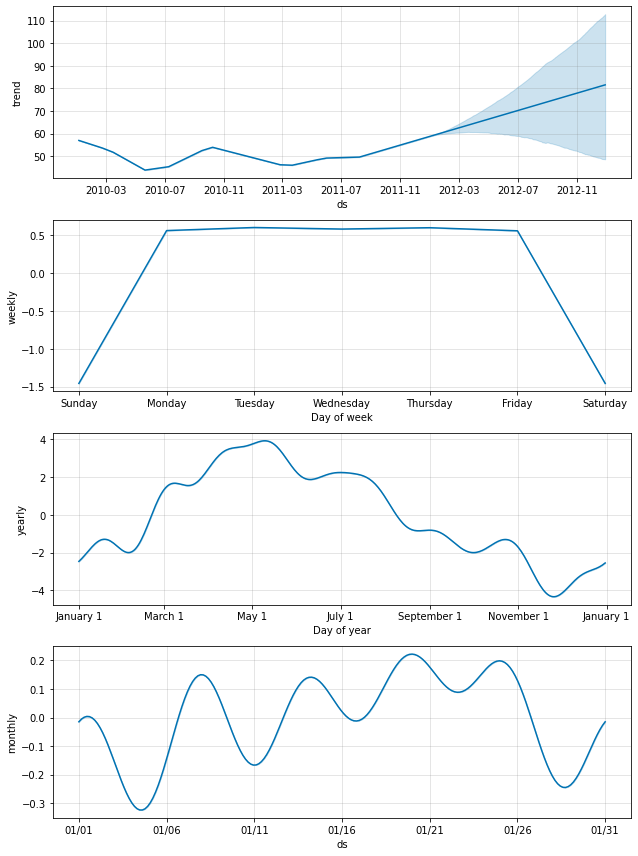

In [63]:
get_components('ABT', year='2010')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


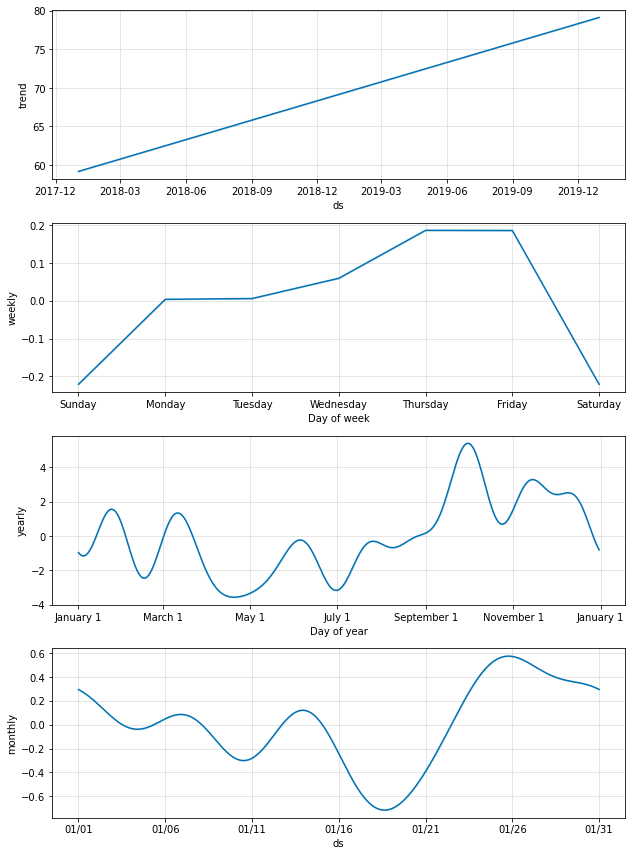

In [64]:
get_components('ABT', year='2018')

Here we see that there is an interesting difference between both the monthly and yearly seasonalities, indicating differences in consumer behavior during a bull and bear market. 


## Data Setup by Sector

To run the experiment, we will organize all the data by sector and run clustering algorithms within each sector as experiment #1

### Computing Market Capitalizations

We are interested in analyzing whether or not there is a concept of "following" the larger cap stocks

In [10]:
from tqdm.notebook import tqdm

In [ ]:
all_tickers = tech_bull_prices['tic'].unique()

In [11]:
market_capitalizations = pd.read_csv('./data/market-capitalization.csv')
market_capitalizations = market_capitalizations[['datadate', 'tic', 'csho']]
market_capitalizations.loc[:, 'datadate'] = pd.to_datetime(market_capitalizations['datadate'], format='%m/%d/%Y')

In [12]:
def get_market_cap(ticker, year=2010):
    ticker_shares = market_capitalizations[market_capitalizations['tic'] == ticker]
    shares_outstanding = ticker_shares[ticker_shares['datadate'].dt.year == year]['csho']
    ticker_price = get_prices(ticker, year=str(year)).iloc[0]['prccd']
    return (ticker_price * shares_outstanding).values[0]

In [13]:
market_caps = {}
for ticker in tqdm(all_tickers):
    try:
        market_caps[ticker] = get_market_cap(ticker)
    except:
        continue

NameError: name 'all_tickers' is not defined

In [31]:
import pickle
with open('market_cap_tech_2010.p', 'wb') as f:
    pickle.dump(market_caps, f)

## Pricing by Sector

In [141]:
# Information Technology GSector: 45

def get_prices_by_sector(year='2010', gsector=45.0):
    if year == '2008':
        return prices_2008[prices_2008['gsector'] == gsector]
    elif year == '2018':
        return prices_2018[prices_2018['gsector'] == gsector]
    else:
        return bull_market_prices[bull_market_prices['gsector'] == gsector]

In [14]:
def compute_yearly_seasonality(df):
    m = Prophet(yearly_seasonality=10, weekly_seasonality=3, daily_seasonality=False, seasonality_mode='additive')
    m.fit(df)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    return forecast['yearly'][:df.shape[0]]

In [143]:
tech_bull_prices = get_prices_by_sector()[['datadate', 'tic', 'prccd']]

### Create Samples

In [151]:
import numpy as np

def get_sample(market_caps):
    vals = list(market_caps.values())
    vals.sort()
    divider = len(vals) // 3
    small_caps = vals[:divider]
    mid_caps = vals[divider:divider * 2]
    large_caps = vals[divider * 2:]
    sample = []
    
    random_small_caps = list(np.random.choice(small_caps, 100))
    random_mid_caps = list(np.random.choice(mid_caps, 100))
    random_large_caps = list(np.random.choice(mid_caps, 100))
    sample_set = random_small_caps + random_mid_caps + random_large_caps 
    
    for cap in sample_set:
        for key in market_caps:
            if market_caps[key] == cap:
                if cap in random_small_caps:
                    sample.append((key, 'small'))
                elif cap in random_mid_caps:
                    sample.append((key, 'mid'))
                else:
                    sample.append((key, 'large'))
                break
    return sample

In [61]:
sample = get_sample(market_caps)

#### Compute Prophet Seasonality Values on the Sample

In [68]:
data = {}
for ticker, size in tqdm(sample):
    prices = tech_bull_prices[tech_bull_prices['tic'] == ticker]
    prophet = format_prophet_data(prices)
    try:
        seasonality = compute_yearly_seasonality(prophet)
    except:
        continue
    data[ticker] = {'symbol': ticker, 'size': size, 'seasonality_vector': seasonality.values} 

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


In [70]:
with open('tech-2010-seasonalities.p', 'wb') as f:
    pickle.dump(data, f)

## Clustering with TSLearn and Dynamic Time-Warping

In [1]:
import pickle
import numpy as np
import pandas as pd
import numpy as np

In [2]:
with open('./tech/tech-2010-seasonalities.p', 'rb') as f:
    seasonalities = pickle.load(f)

In [81]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [237]:
dataset = []
for value in seasonalities:
    dataset.append(seasonalities[value]['seasonality_vector'])    

In [82]:
X = to_time_series_dataset(dataset)
X = TimeSeriesScalerMeanVariance().fit_transform(X)

In [3]:
from tslearn.clustering import TimeSeriesKMeans

/Users/brandonfan/opt/anaconda3/envs/stocks/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/brandonfan/opt/anaconda3/envs/stocks/lib/python3.8/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [116]:
clf = TimeSeriesKMeans(n_clusters=4, metric='dtw', max_iter=10, n_jobs=3)

In [117]:
clf.fit(X)
y = clf.predict(X)

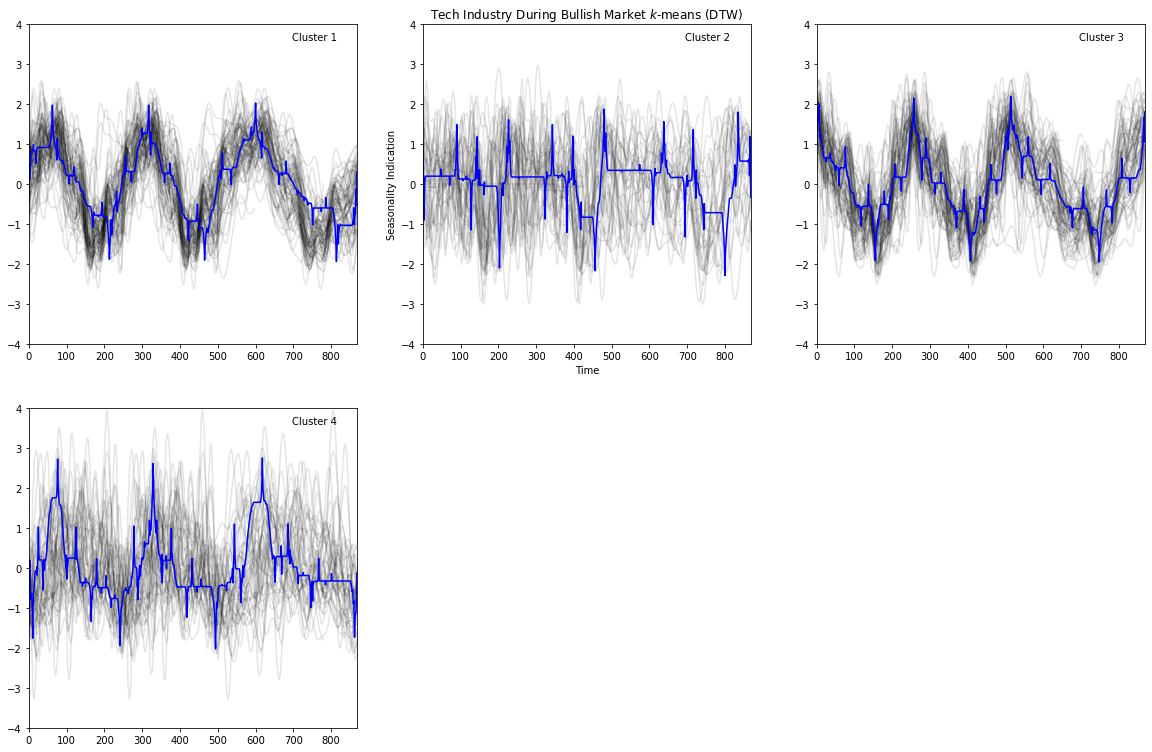

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

sz = X.shape[1]
fig = plt.figure(figsize=(20, 20))
for yi in range(4):
    plt.subplot(3, 3, yi + 1)
    for xx in X[y == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(clf.cluster_centers_[yi].ravel(), "b-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.80, 0.95,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Tech Industry During Bullish Market $k$-means (DTW)")
        plt.xlabel('Time')
        plt.ylabel('Seasonality Indication')

In [127]:
fig.savefig('bullish-market-tech-clustering.png', bbox_inches='tight', dpi=250)

In [128]:
clf.to_pickle('tech/bullish-market-tech-model.p')

## Bear Market Analysis

In [202]:
tech_bear_prices = get_prices_by_sector(year='2008')[['datadate', 'tic', 'prccd']]
bear_tickers = tech_bear_prices['tic'].unique()

In [203]:
bear_market_caps = {}
for ticker in tqdm(bear_tickers):
    try:
        bear_market_caps[ticker] = get_market_cap(ticker)
    except:
        continue

In [204]:
with open('tech/market_cap_tech_2008.p', 'wb') as f:
    pickle.dump(bear_market_caps, f)

In [205]:
bear_sample = get_sample(bear_market_caps)

In [206]:
data = {}
for ticker, size in tqdm(bear_sample):
    prices = tech_bear_prices[tech_bear_prices['tic'] == ticker]
    prophet = format_prophet_data(prices)
    try:
        seasonality = compute_yearly_seasonality(prophet)
    except:
        continue
    data[ticker] = {'symbol': ticker, 'size': size, 'seasonality_vector': seasonality.values} 

In [207]:
with open('tech/tech-2008-seasonalities.p', 'wb') as f:
    pickle.dump(data, f)

In [208]:
with open('./tech/tech-2008-seasonalities.p', 'rb') as f:
    bear_seasonalities = pickle.load(f)

In [243]:
dataset = []
for value in bear_seasonalities:
    dataset.append(bear_seasonalities[value]['seasonality_vector'])
    
X = to_time_series_dataset(dataset)
X = TimeSeriesScalerMeanVariance().fit_transform(X)

In [210]:
clf_bear = TimeSeriesKMeans(n_clusters=4, metric='dtw', max_iter=10, n_jobs=3)

In [211]:
clf_bear.fit(X)
y = clf_bear.predict(X)

In [67]:
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s = numpy.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w = numpy.ones(window_len,'d')
        else:  
                w = eval('numpy.'+window+'(window_len)')
        y = numpy.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

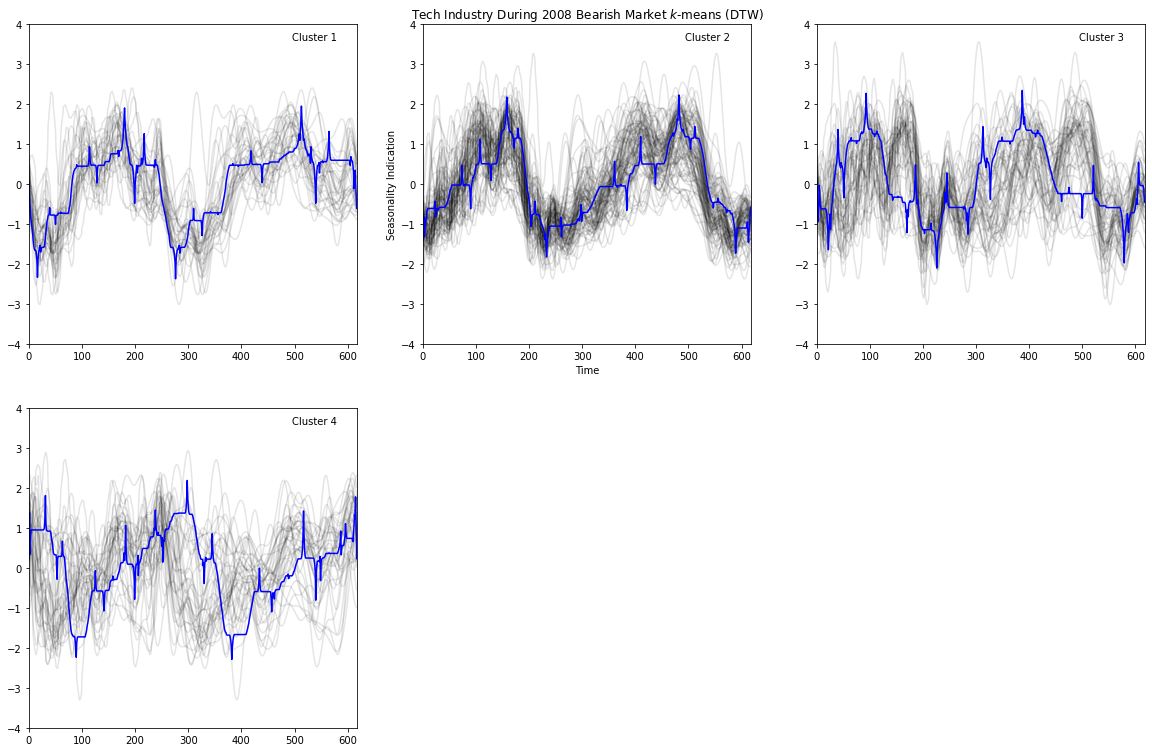

In [212]:
sz = X.shape[1]
fig = plt.figure(figsize=(20, 20))
for yi in range(4):
    plt.subplot(3, 3, yi + 1)
    for xx in X[y == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(smooth(clf_bear.cluster_centers_[yi].ravel()), "b-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.80, 0.95,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Tech Industry During 2008 Bearish Market $k$-means (DTW)")
        plt.xlabel('Time')
        plt.ylabel('Seasonality Indication')

In [215]:
fig.savefig('bearish-market-tech-clustering-2008.png', bbox_inches='tight', dpi=250)

In [214]:
clf_bear.to_pickle('tech/bearish-market-tech-model.p')

## 2018 Bear Market Analysis

In [185]:
tech_bear_prices = get_prices_by_sector(year='2018')[['datadate', 'tic', 'prccd']]
bear_tickers = tech_bear_prices['tic'].unique()
bear_market_caps = {}
for ticker in tqdm(bear_tickers):
    try:
        bear_market_caps[ticker] = get_market_cap(ticker)
    except:
        continue

In [186]:
with open('tech/market_cap_tech_2018.p', 'wb') as f:
    pickle.dump(bear_market_caps, f)

In [187]:
bear_sample = get_sample(bear_market_caps)

In [188]:
data = {}
for ticker, size in tqdm(bear_sample):
    prices = tech_bear_prices[tech_bear_prices['tic'] == ticker]
    prophet = format_prophet_data(prices)
    try:
        seasonality = compute_yearly_seasonality(prophet)
    except:
        continue
    data[ticker] = {'symbol': ticker, 'size': size, 'seasonality_vector': seasonality.values} 

INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


In [189]:
with open('tech/tech-2018-seasonalities.p', 'wb') as f:
    pickle.dump(data, f)

In [190]:
with open('./tech/tech-2018-seasonalities.p', 'rb') as f:
    bear_seasonalities = pickle.load(f)

In [191]:
dataset = []
for value in bear_seasonalities:
    dataset.append(bear_seasonalities[value]['seasonality_vector'])
    
X = to_time_series_dataset(dataset)
X = TimeSeriesScalerMeanVariance().fit_transform(X)

In [192]:
clf_bear = TimeSeriesKMeans(n_clusters=4, metric='dtw', max_iter=10, n_jobs=3)

In [193]:
clf_bear.fit(X)
y = clf_bear.predict(X)

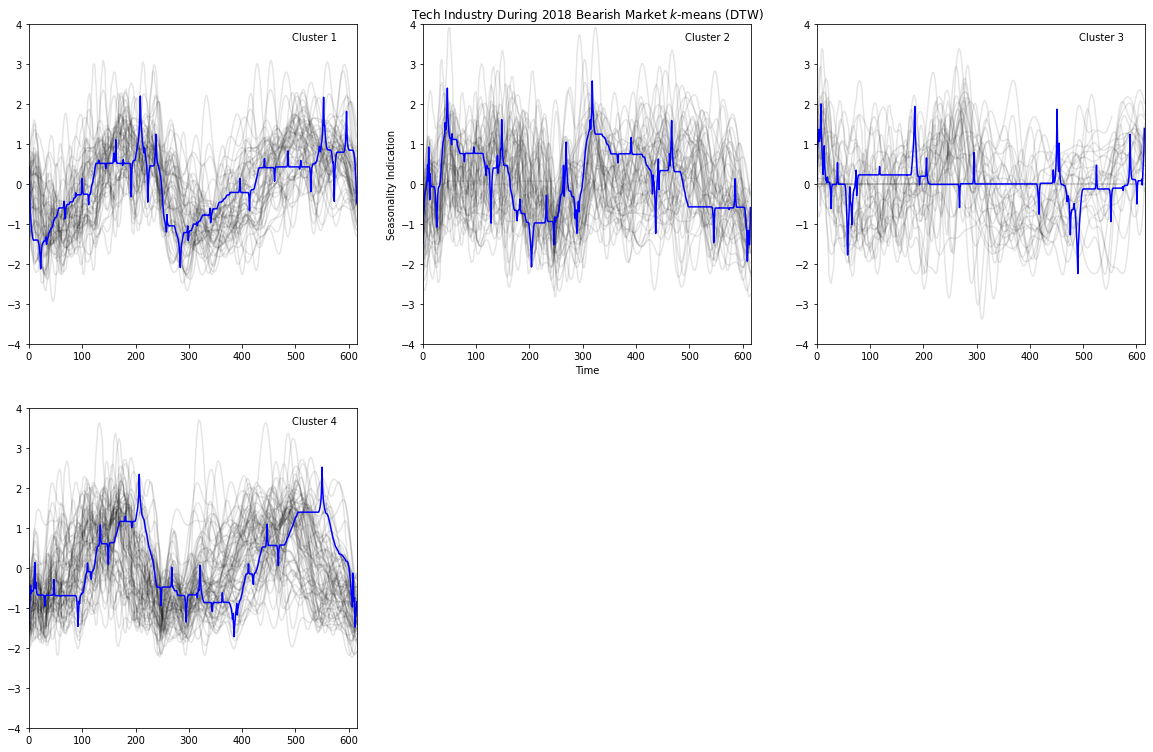

In [199]:
sz = X.shape[1]
fig = plt.figure(figsize=(20, 20))
for yi in range(4):
    plt.subplot(3, 3, yi + 1)
    for xx in X[y == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(clf_bear.cluster_centers_[yi].ravel(), "b-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.80, 0.95,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Tech Industry During 2018 Bearish Market $k$-means (DTW)")
        plt.xlabel('Time')
        plt.ylabel('Seasonality Indication')

In [200]:
fig.savefig('bearish-market-tech-clustering.png', bbox_inches='tight', dpi=250)

In [201]:
clf_bear.to_pickle('tech/2018-bearish-market-tech-model.p')

## Analysis-Based on Market Capitalizations

### Bear Market

In [399]:
dataset = []
for value in bear_seasonalities:
    dataset.append(bear_seasonalities[value]['seasonality_vector'])
    
X = to_time_series_dataset(dataset)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
y = clf_bear.predict(X)

In [400]:
tickers = list(bear_seasonalities.keys())

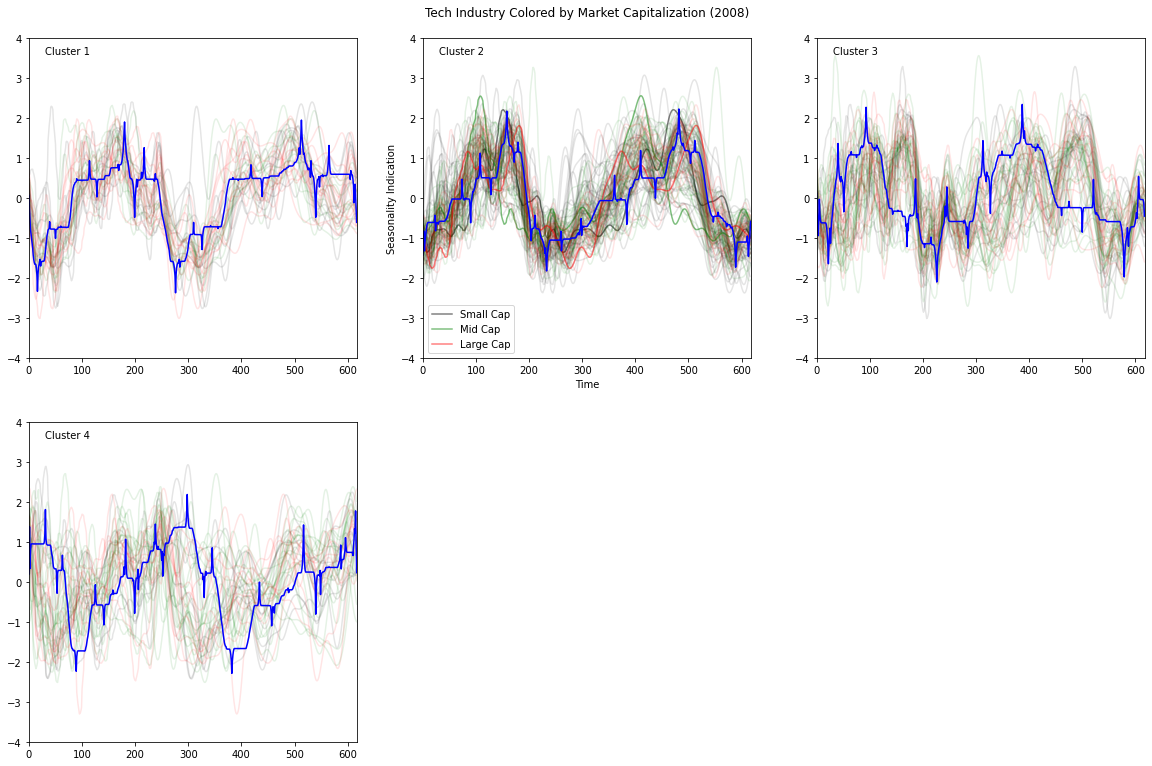

In [299]:
import matplotlib.pyplot as plt
import seaborn as sns

sz = X.shape[1]
fig = plt.figure(figsize=(20, 20))
for yi in range(4):
    plt.subplot(3, 3, yi + 1)
    is_first_small = False
    is_first_mid = False
    is_first_large = False
    for xx in X[y == yi]:
        i = np.where(X == xx)[0][0]
        
        if bear_seasonalities[tickers[i]]['size'] == 'small':
            if not is_first_small and yi == 1:
                plt.plot(xx.ravel(), "k-", alpha=0.5, label='Small Cap')
                is_first_small = True
            else:
                plt.plot(xx.ravel(), "k-", alpha=.1)
        elif bear_seasonalities[tickers[i]]['size'] == 'mid':
            if not is_first_mid and yi == 1:
                plt.plot(xx.ravel(), 'g-', alpha=0.5, label='Mid Cap')
                is_first_mid = True
            else:
                plt.plot(xx.ravel(), 'g-', alpha=.1)
        else:
            if not is_first_large and yi == 1:
                plt.plot(xx.ravel(), 'r-', alpha=0.5, label='Large Cap')
                is_first_large = True
            else:
                plt.plot(xx.ravel(), "r-", alpha=.1)
    plt.plot(clf_bear.cluster_centers_[yi].ravel(), "b-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.05, 0.95,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.legend()
    if yi == 1:
        title = plt.title("Tech Industry Colored by Market Capitalization (2008)")
        title.set_position([.5, 1.05])
        plt.xlabel('Time')
        plt.ylabel('Seasonality Indication')

In [300]:
fig.savefig('tech-bear-market-by-market-cap.png', bbox_inches='tight', dpi=250)

### Bull Market

In [411]:
dataset = []
for value in seasonalities:
    dataset.append(seasonalities[value]['seasonality_vector'])    

tickers = list(seasonalities.keys())
X = to_time_series_dataset(dataset)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
y = clf.predict(X)

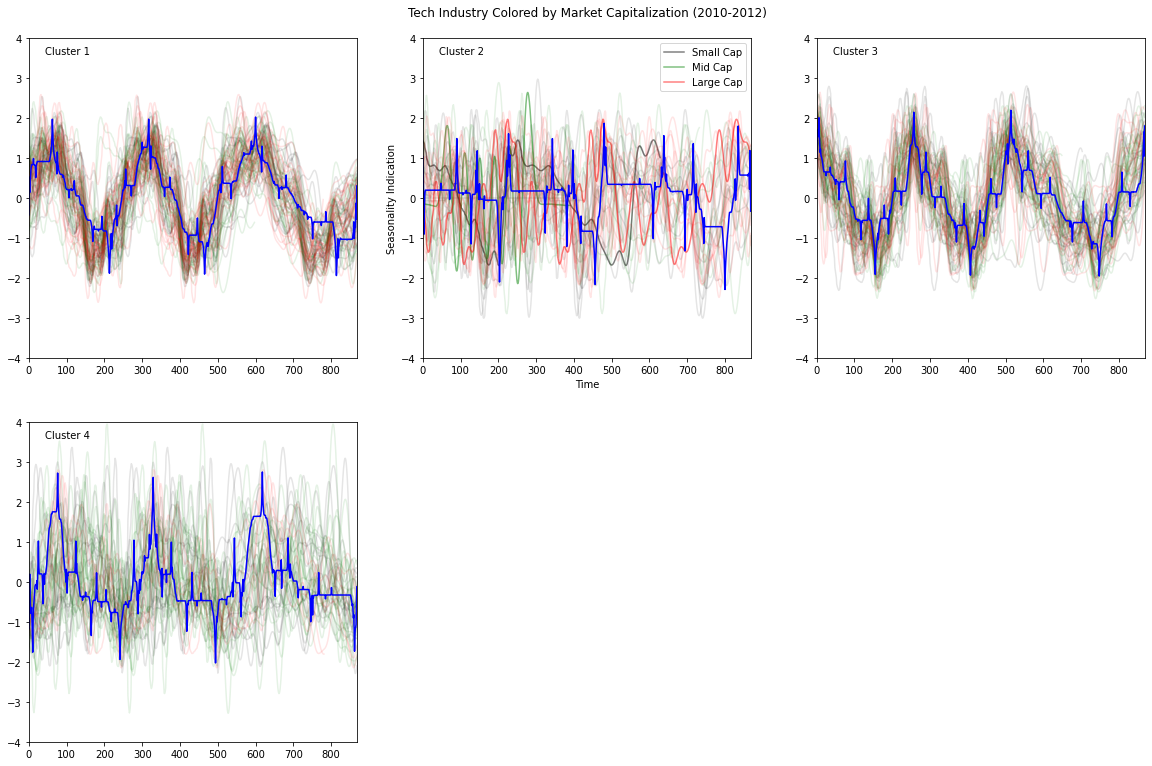

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns

sz = X.shape[1]
fig = plt.figure(figsize=(20, 20))
for yi in range(4):
    plt.subplot(3, 3, yi + 1)
    is_first_small = False
    is_first_mid = False
    is_first_large = False
    for xx in X[y == yi]:
        i = np.where(X == xx)[0][0]
        
        if seasonalities[tickers[i]]['size'] == 'small':
            if not is_first_small and yi == 1:
                plt.plot(xx.ravel(), "k-", alpha=0.5, label='Small Cap')
                is_first_small = True
            else:
                plt.plot(xx.ravel(), "k-", alpha=.1)
        elif seasonalities[tickers[i]]['size'] == 'mid':
            if not is_first_mid and yi == 1:
                plt.plot(xx.ravel(), 'g-', alpha=0.5, label='Mid Cap')
                is_first_mid = True
            else:
                plt.plot(xx.ravel(), 'g-', alpha=.1)
        else:
            if not is_first_large and yi == 1:
                plt.plot(xx.ravel(), 'r-', alpha=0.5, label='Large Cap')
                is_first_large = True
            else:
                plt.plot(xx.ravel(), "r-", alpha=.1)
    plt.plot(clf.cluster_centers_[yi].ravel(), "b-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.05, 0.95,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
        
    if yi == 1:
        title = plt.title("Tech Industry Colored by Market Capitalization (2010-2012)")
        title.set_position([.5, 1.05])
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Seasonality Indication')

In [294]:
fig.savefig('tech-bull-market-by-market-cap.png', bbox_inches='tight', dpi=250)

## Exploring Explanations Behind Clusters

In [322]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [401]:
company_desc = pd.read_csv('./data/company-descriptions.csv')

In [412]:
def get_company_description(ticker):
    return company_desc[company_desc['tic'] == ticker].iloc[0]['busdesc']

In [413]:
company_descriptions = []
for ticker in tickers:
    company_descriptions.append(get_company_description(ticker))

In [423]:
# get first cluster descriptions
desired_descriptions = []
values = X[y == 0]
for value in values:
    i = np.where(X == value)[0][0]
    desired_descriptions.append(company_descriptions[i])

In [424]:
descriptions = pd.Series(desired_descriptions)

# remove punctuation and make lowercase
descriptions = descriptions.map(lambda x: re.sub('[,\.!?]', '', x))
descriptions = descriptions.map(lambda x: x.lower())

In [425]:
count_vectorizer = CountVectorizer(stop_words='english')

In [426]:
count_data = count_vectorizer.fit_transform(descriptions)

In [427]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [428]:
number_topics = 5
number_words = 25

lda = LDA(n_components=number_topics)
lda.fit(count_data)

LatentDirichletAllocation(n_components=5)

In [429]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
solutions provides services operates segments worldwide technology corporation software company products semiconductor markets network business america marketing communications based states united management develops designs enterprise

Topic #1:
manufactures worldwide designs sells develops subsidiaries semiconductor solutions operates power software segments systems company markets devices products corporation components security group electronic international management applications

Topic #2:
systems solutions company manufacturing services provides offers integrated corporation develops based imaging hardware design assurance communications software canada worldwide tollgrade radiant complex network electronics equipment

Topic #3:
provides united states products subsidiaries solutions internationally markets services technologies software designs manufactures technology communications industry systems wireless develops applications company sells h